### Instructions

1. Plug in the `model_path`
2. From `Run` menu, select `Restart Kernel and Run All Cells`
3. From `View` menu, select `Collapse All Code`

In [1]:
model_path = '/data00/projects/megameta/scripts/jupyter_megameta/l1analysis/stanford_ks2/task-fund_model-bin3.json'

In [2]:
import os, glob, re, sys, json, copy  

import nipype.interfaces.io as nio           
import nipype.interfaces.spm as spm    
import nipype.interfaces.matlab as mlab     
import nipype.pipeline.engine as pe 
import nipype.interfaces.utility as util

import pandas as pd
import numpy as np
import scipy as sp
import scipy.io as sio

from nilearn import plotting

In [3]:
def ensure_list(obj):
    if type(obj) is not list:
        return [obj]
    else:
        return obj

def copy_from_template(target, template):
    for key, item in template.items():
        if key not in target.keys():
            target[key] = copy.deepcopy(template[key])
        elif type(item) is dict:
            copy_from_template(target[key], template[key])

In [4]:
with open(model_path, 'r') as f:
    model = json.load(f)

for template_path in ensure_list(model.get("Template", [])):
    with open(template_path, 'r') as f:
        template = json.load(f)
    copy_from_template(model, template)
    
env = model['Environment']
job_name = 'task-{}_model-{}'.format(model['Info']['task'], model['Info']['model'])

In [5]:
mlab.MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(env["spm_path"])

In [6]:
con_df = []
print("Aggregating contrast files...")

for sub_folder in glob.glob(os.path.join(env['output_path'], job_name, 'sub-*')):
    
    if not os.path.isdir(sub_folder):
        continue
    
    sub = os.path.basename(sub_folder)
    
    spm_file = os.path.join(sub_folder, 'SPM.mat')
    if not os.path.exists(spm_file):
        continue
    
    spm_mat = sio.loadmat(spm_file, 
               squeeze_me=True, struct_as_record=False)
    
    for n, con in enumerate(spm_mat['SPM'].xCon, start=1):
        con_file = os.path.join(sub_folder, f"con_{n:04d}.nii")
        if os.path.exists(con_file):
            con_df.append({'sub': sub,
                          'con': con.name,
                          'path': con_file})
        
con_df = pd.DataFrame(con_df)
con_df.to_csv(os.path.join(env['output_path'], job_name, 'contrasts.csv'), index=False)
con_df.pivot_table(index='con', values='sub', aggfunc='count')

Aggregating contrast files...


,sub
con,
non_message_event,32
pure_message_0.0,32
pure_message_1.0,32
pure_message_2.0,32
pure_message_2.0 > pure_message_0.0,32


In [7]:
def get_contrast_files(contrast_name, contrast_df):
    return contrast_df.query(f'con == "{contrast_name}"').path.tolist()

In [8]:
l2analysis_path = os.path.join(env['output_path'], job_name, "l2analysis")

In [9]:
l2analysis = pe.Workflow(base_dir=os.path.join(env['working_path'], job_name), name='l2analysis')

infosource = pe.Node(util.IdentityInterface(fields=['contrast_name']),
                  name="infosource")
infosource.iterables = ('contrast_name', con_df.con.unique().tolist())

getcontrastfiles = pe.Node(util.Function(input_names=['contrast_name', 'contrast_df'],
                                        output_names=['contrast_files'],
                                        function=get_contrast_files),
                    name='getcontrastfiles')
getcontrastfiles.inputs.contrast_df = con_df

# One Sample T-Test Design - creates one sample T-Test Design
onesamplettestdes = pe.Node(spm.OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimate the parameters of the model
level2estimate = pe.Node(spm.EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates simple group contrast
level2conestimate = pe.Node(spm.EstimateContrast(group_contrast=True), 
                            name="level2conestimate")
cont = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont]

# Datasink - creates output folder for important outputs
datasink = pe.Node(nio.DataSink(base_directory=l2analysis_path), 
                   name="datasink")
datasink.inputs.substitutions = [('_contrast_name_', '')]

# Connect workflow
l2analysis.connect([(infosource, getcontrastfiles, [('contrast_name', 'contrast_name')]),
                    (getcontrastfiles, onesamplettestdes, [('contrast_files', 'in_files')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')] ),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '@spm_mat'),
                                                   ('spmT_images',
                                                    '@T'),
                                                   ('con_images',
                                                    '@con')])
                   ])

l2analysis.run()

201217-10:45:12,17 nipype.workflow INFO:
	 Workflow l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
201217-10:45:12,239 nipype.workflow INFO:
	 Running serially.
201217-10:45:12,241 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.getcontrastfiles" in "/fmriNASTest/data00/projects/megameta/stanford_ks2/working/nipype/task-fund_model-bin3/l2analysis/_contrast_name_pure_message_2.0pure_message_0.0/getcontrastfiles".
201217-10:45:12,422 nipype.workflow INFO:
	 [Node] Running "getcontrastfiles" ("nipype.interfaces.utility.wrappers.Function")
201217-10:45:12,530 nipype.workflow INFO:
	 [Node] Finished "l2analysis.getcontrastfiles".
201217-10:45:12,532 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.onesampttestdes" in "/fmriNASTest/data00/projects/megameta/stanford_ks2/working/nipype/task-fund_model-bin3/l2analysis/_contrast_name_pure_message_2.0pure_message_0.0/onesampttestdes".
201217-10:45:12,682 nipype.workflow INFO:
	 [Node] Running "onesampttestdes" ("n

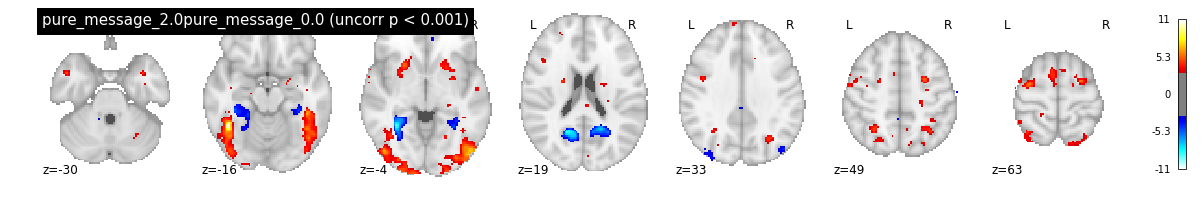

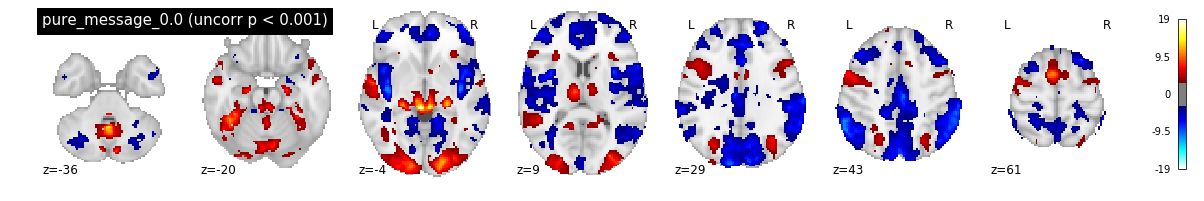

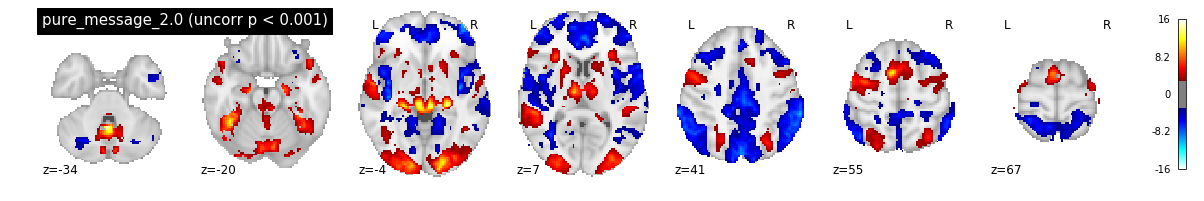

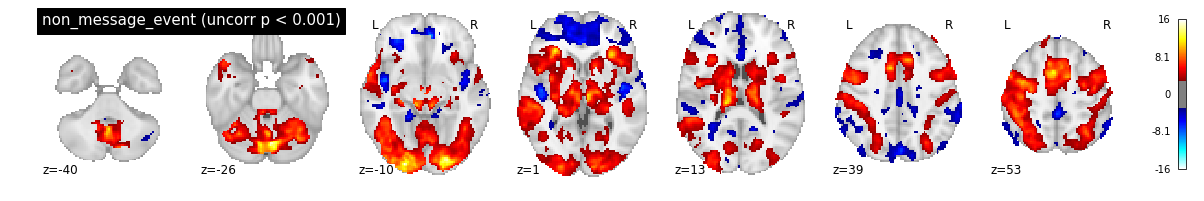

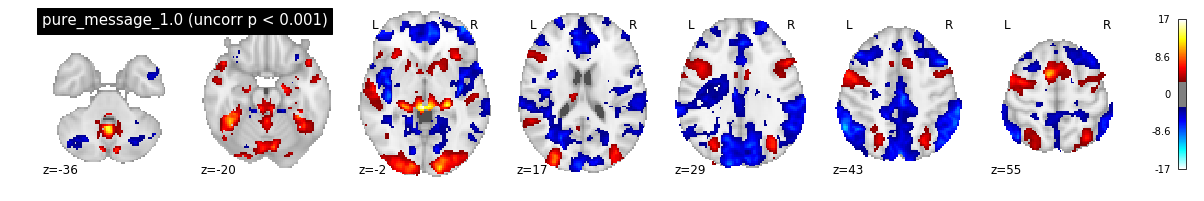

In [10]:
p_val = 0.001
p001_uncorrected = sp.stats.norm.isf(p_val)

for con_folder in glob.glob(os.path.join(l2analysis_path, "*")):
    if not os.path.isdir(con_folder):
        continue
    
    con_name = os.path.basename(con_folder)
    t_map = os.path.join(con_folder, "spmT_0001.nii")
    
    if not os.path.exists(t_map):
        continue
    
    plotting.plot_stat_map(
        t_map, threshold=p001_uncorrected, colorbar=True, display_mode='z',
        title=f'{con_name} (uncorr p < 0.001)')
    
    plotting.show()